[![alt text](https://avatars1.githubusercontent.com/u/59831504?s=400&v=4 "MtheEPIC User Icon")](https://github.com/MtheEPIC/KaggleProj)

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set() 
from sklearn.preprocessing import binarize
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, plot_roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
supSize = 25
titleSize = 20
labelSize = 15
tickSize = 13

---
# Setup Data

## Load & Display Data
[Kaggle Dataset](https://www.kaggle.com/ntnu-testimon/paysim1 "Synthetic Financial Datasets For Fraud Detection")

In [3]:
df = pd.read_csv('data/card.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Check Value Type

In [4]:
print("data types\n{}".format(df.info()))
print("\nnull values:\n{}".format(df.isnull().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
data types
None

null values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


## Define Each Feature

### We have 11 initial features:

* **step:** Maps a unit of time in the real world. In this case 1 step is 1 hour of time, 743 is the end of the month
* **type:** CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER
* **amount:** amount of the transaction in local currency _(may be bigger then the account balance)_
* **nameOrig:** customer who started the transaction _(start with C for customer)_
* **oldbalanceOrg:** initial balance before the transaction _(at least 0)_
* **newbalanceOrig:** customer's balance after the transaction. _(at least 0)_
* **nameDest:** recipient ID of the transaction. _(start with C for customer)_
* **oldbalanceDest:** initial recipient balance before the transaction. _(at least 0)_
* **newbalanceDest:** recipient's balance after the transaction. _(at least 0)_
* **isFraud:** identifies a fraudulent transaction (1) and non fraudulent (0)
* **isFlaggedFraud:** flags illegal attempts to transfer more than 200.000 in a single transaction.

---
# Data Trends

### Transaction Types

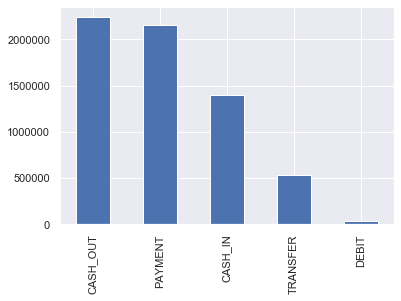

In [5]:
df['type'].value_counts().plot.bar()
plt.show()

In [6]:
precent = df['type'].value_counts(normalize=True)['DEBIT']*100
lines = df[df['type'] == 'DEBIT']['type'].value_counts()['DEBIT']
print("The precent of DEBIT in the Data Set is {:.2f}% ({} lines)".format(precent, lines))

The precent of DEBIT in the Data Set is 0.65% (41432 lines)


### Fraud happens aroud 0.13%

In [7]:
"{:.2f}%".format(df['isFraud'].value_counts(normalize=True)[1]*100)

'0.13%'

### Fraud is only in: TRANSFER, CASH OUT
#### (at about the same amount)

In [8]:
fraud = df[df['isFraud'] == 1]
fraud['type'].value_counts(normalize=True)*100

CASH_OUT    50.11567
TRANSFER    49.88433
Name: type, dtype: float64

### Precentage of Transfer Fraud is about 0.77%

In [9]:
df[df['type'] == 'TRANSFER']['isFraud'].value_counts(normalize=True)[1]*100

0.7687991758442811

### Precentage of Cash Out Fraud is about 0.18%

In [10]:
df[df['type'] == 'CASH_OUT']['isFraud'].value_counts(normalize=True)[1]*100

0.18395530726256984

### If The Transaction Amount Was The Same As The Balance: Its Fraud

In [11]:
df[df['amount'] == df['oldbalanceOrg']]['isFraud'].unique()

array([1], dtype=int64)

### If the Existing Fraud Detection Flags the Transaction as Fraud, It's Fraud

In [12]:
df[df['isFlaggedFraud'] == 1]['isFraud'].unique()

array([1], dtype=int64)

### All initiates are customers

In [13]:
df['nameOrig'].str[:1].unique()

array(['C'], dtype=object)

### Recipients are both customers and merchants

In [14]:
df['nameDest'].str[:1].unique()

array(['M', 'C'], dtype=object)

### proper recipients (merchants) do not fraud

In [15]:
df[df['isFraud']==1]['nameDest'].str[:1].unique()

array(['C'], dtype=object)

### Customers who Commited Fraud also Have Legit Transactions

In [16]:
fraudDoers = df[df['isFraud']==1]['nameDest'].unique()
df[df['nameDest']==fraudDoers[0]].head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
6167,6,TRANSFER,109985.65,C570434649,41851.00,0.00,C553264065,0.00,109985.65,0,0
7903,7,CASH_IN,10256.20,C111105514,3766080.24,3776336.45,C553264065,109985.65,99729.44,0,0
16381,8,CASH_OUT,111622.39,C1457214570,2347.00,0.00,C553264065,99729.44,5254.44,0,0
20003,8,CASH_IN,206097.39,C161724858,1991.12,208088.52,C553264065,211351.84,5254.44,0,0


### People who had been scamed had only one transaction in there acount

In [17]:
fraudRecipients = df[df['isFraud']==1]['nameOrig']
print(len(fraudRecipients))
print(len(fraudRecipients.unique()))

8213
8213


### People with only one transaction ...

In [18]:
fraudRecipients = df['nameOrig']
# print(len(fraudRecipients))
# print(len(fraudRecipients.unique()))
fraudRecipientsValues = fraudRecipients.value_counts()
fraudRecipientsValues[9298:]
df[df['isFraud']==1]['nameOrig']

2          C1305486145
3           C840083671
251        C1420196421
252        C2101527076
680         C137533655
              ...     
6362615     C786484425
6362616    C1529008245
6362617    C1162922333
6362618    C1685995037
6362619    C1280323807
Name: nameOrig, Length: 8213, dtype: object

### Though in general there are more Initiates then Recipients, In Fraudulent Transactions it's the other way

In [19]:
print("In Total:")
print("The Number Of Initiates is: {}".format(len(df['nameOrig'].unique())))
print("The Number Of Recipients is: {}".format(len(df['nameDest'].unique())))
print("In Fraudulent Transactions:")
print("The Number Of Initiates is: {}".format(len(df[df['isFraud']==1]['nameOrig'].unique())))
print("The Number Of Recipients is: {}".format(len(df[df['isFraud']==1]['nameDest'].unique())))

In Total:
The Number Of Initiates is: 6353307
The Number Of Recipients is: 2722362
In Fraudulent Transactions:
The Number Of Initiates is: 8213
The Number Of Recipients is: 8169


### Almost all of the fraudulent transactions where when the amount in the transaction was the same as the account balance

In [20]:
dfFraud = df[df['isFraud']==1][['amount', 'oldbalanceOrg']]
precent = dfFraud[dfFraud['amount']!=dfFraud['oldbalanceOrg']].shape[0]/dfFraud.shape[0]*100
print("The precentage of fraudulent transaction that didn't take the hull balace of the customer is {}%".format(precent))

The precentage of fraudulent transaction that didn't take the hull balace of the customer is 2.1794715694630464%


### The destination account doesn't seem to update according to the transferred amount, probebly to simulate the bank verifying the transaction

In [21]:
amount = df.loc[10]['amount']
delta = df.loc[10]['newbalanceDest'] - df.loc[10]['oldbalanceDest']
print('the amount transferred ({}) doesn\'t match the change in the destination account ({})'.format(amount, delta))

the amount transferred (9644.94) doesn't match the change in the destination account (147137.12)


### check if step helps in finding if fraud exists

isFraud    0
dtype: int64

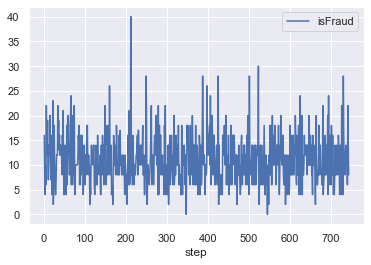

In [22]:
tmp = df[['step', 'isFraud']]
tmp.groupby(['step']).sum().plot()
tmp.groupby(['step']).sum().min()

change step to times of day 0-23

isFraud    274
dtype: int64

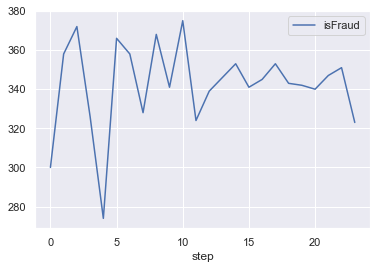

In [23]:
tmp = df[['step', 'isFraud']]%24
# tmp['step'] = tmp['step']%24
tmp.groupby(['step']).sum().plot()
tmp.groupby(['step']).sum().min()

C:\Users\mthee\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


isFraud    220
dtype: int64

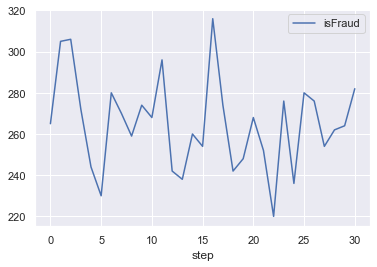

In [24]:
tmp = df[['step', 'isFraud']]
tmp['step'] = tmp['step']//24
tmp.groupby(['step']).sum().plot()
tmp.groupby(['step']).sum().min()

step doesn't realy help us

---
# Predict Fraud

In [7]:
def normalize(df):
    for x in df:
        df[x] = df[x]/df[x].max()

## Clear data from unneeded values for the model

### remove transactions types with no fraud _(to reduce run time)_
We'll take care of that together with the next point

### Change transactions dtype to numeric 
#### note that dummy classifiers makes models slow
```
tmp = pd.get_dummies(data['type'])
data = data.join(tmp)
data = data.drop('type', axis=1)
data.head()
```

In [26]:
# df[df['type'].isin(['TRANSFER', 'CASH_OUT'])]

In [9]:
# d1 = df[df['type']=='TRANSFER']
# d2 = df[df['type']=='CASH_OUT']
# d1['type'] = 1
# d2['type'] = 0
# df = pd.concat([d1, d2])
# df.head()
tmp = pd.get_dummies(df['type'])
df = df.join(tmp)
df = df.drop('type', axis=1)
df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0,0,1,0
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0,0,1,0
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,0,0,0,1
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,1,0,0,0
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,0,0,1,0


### Remove the unneeded columns

In [10]:
# df = df.drop(['nameOrig', 'nameDest'], axis=1)
df = df.select_dtypes(exclude='object')
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,0,1,0


In [11]:
normalize(df)
df_clean = df.copy()
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0.001346,0.000106,0.002855,0.003233,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.001346,0.000020,0.000357,0.000391,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.001346,0.000002,0.000003,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.001346,0.000002,0.000003,0.000000,0.000059,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.001346,0.000126,0.000697,0.000603,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [12]:
df = df.drop('step', axis=1)
df.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0.000106,0.002855,0.003233,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000020,0.000357,0.000391,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.000002,0.000003,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.000002,0.000003,0.000000,0.000059,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.000126,0.000697,0.000603,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
X=df.drop('isFraud', axis=1)
y=df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Train
We'll be trying to achieve high sensitivity in our models

In [14]:
def evaluate(true, pred):
    model_accuracy = roc_auc_score(true, pred)
    null_accuracy = roc_auc_score(true, true.replace(1, 0))
    
    print("Null AUC Score: {:.5f}".format(null_accuracy))
    print("Model AUC Score: {:.5f}".format(model_accuracy))

    if null_accuracy >= model_accuracy:
        print("The model isn't effective")
#         return
    print("The model is better then a 'dumb' model")
    print("confusion_matrix:\n", confusion_matrix(true, pred))
    print(classification_report(true, pred))

### Logistic Regression

In [33]:
lr = LogisticRegression(random_state=0, solver='lbfgs', max_iter=200)
lr.fit(X_train,y_train)
predictions = lr.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.54708
The model is better then a 'dumb' model
confusion_matrix:
 [[552400      4]
 [  1520    158]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.98      0.09      0.17      1678

    accuracy                           1.00    554082
   macro avg       0.99      0.55      0.59    554082
weighted avg       1.00      1.00      1.00    554082



In [34]:
y_pred = lr.predict_proba(X_test)[:, 1]
y_pred_class = binarize([y_pred], 2e-3)[0]
evaluate(y_test, y_pred_class)

Null AUC Score: 0.50000
Model AUC Score: 0.80961
The model is better then a 'dumb' model
confusion_matrix:
 [[418110 134294]
 [   231   1447]]
              precision    recall  f1-score   support

         0.0       1.00      0.76      0.86    552404
         1.0       0.01      0.86      0.02      1678

    accuracy                           0.76    554082
   macro avg       0.51      0.81      0.44    554082
weighted avg       1.00      0.76      0.86    554082



In [35]:
y_pred_class = binarize([y_pred], 1e-3)[0]
evaluate(y_test, y_pred_class)

Null AUC Score: 0.50000
Model AUC Score: 0.51332
The model is better then a 'dumb' model
confusion_matrix:
 [[ 17681 534723]
 [     9   1669]]
              precision    recall  f1-score   support

         0.0       1.00      0.03      0.06    552404
         1.0       0.00      0.99      0.01      1678

    accuracy                           0.03    554082
   macro avg       0.50      0.51      0.03    554082
weighted avg       1.00      0.03      0.06    554082



### Decision Tree

In [36]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
predictions = dtc.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.94264
The model is better then a 'dumb' model
confusion_matrix:
 [[552242    162]
 [   192   1486]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.90      0.89      0.89      1678

    accuracy                           1.00    554082
   macro avg       0.95      0.94      0.95    554082
weighted avg       1.00      1.00      1.00    554082



### Random forest

In [37]:
rf = RandomForestClassifier(max_depth=None, random_state=0, n_estimators=10)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.88169
The model is better then a 'dumb' model
confusion_matrix:
 [[552386     18]
 [   397   1281]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.99      0.76      0.86      1678

    accuracy                           1.00    554082
   macro avg       0.99      0.88      0.93    554082
weighted avg       1.00      1.00      1.00    554082



In [38]:
parm_grid = dict(n_estimators=np.arange(6, 13, 1), min_samples_leaf=np.arange(1, 4), max_features=[None, 'log2', 'sqrt'])
grid = RandomizedSearchCV(rf, parm_grid, cv=3, scoring='roc_auc', n_iter=2, random_state=0)
# grid = GridSearchCV(clf, parm_grid, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_params_)

{'n_estimators': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


In [39]:
rf = grid.best_estimator_
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.88288
The model is better then a 'dumb' model
confusion_matrix:
 [[552382     22]
 [   393   1285]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.98      0.77      0.86      1678

    accuracy                           1.00    554082
   macro avg       0.99      0.88      0.93    554082
weighted avg       1.00      1.00      1.00    554082



In [40]:
rfBoost = AdaBoostClassifier(base_estimator=rf, n_estimators=10, random_state=0)
rfBoost.fit(X_train, y_train)
predictions = rfBoost.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.90102
The model is better then a 'dumb' model
confusion_matrix:
 [[552346     58]
 [   332   1346]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.96      0.80      0.87      1678

    accuracy                           1.00    554082
   macro avg       0.98      0.90      0.94    554082
weighted avg       1.00      1.00      1.00    554082



In [41]:
# grid adaboost
parm_grid = dict(n_estimators=np.arange(5, 15, 1), learning_rate=np.linspace(0, 3, 30))
grid = RandomizedSearchCV(rfBoost, parm_grid, cv=3, scoring='roc_auc', n_iter=2, random_state=0, n_jobs=4)
grid.fit(X_train, y_train)
print(grid.best_params_)
predictions = grid.predict(X_test)
evaluate(y_test, predictions)

{'n_estimators': 7, 'learning_rate': 1.7586206896551724}
Null AUC Score: 0.50000
Model AUC Score: 0.89982
The model is better then a 'dumb' model
confusion_matrix:
 [[552340     64]
 [   336   1342]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.95      0.80      0.87      1678

    accuracy                           1.00    554082
   macro avg       0.98      0.90      0.93    554082
weighted avg       1.00      1.00      1.00    554082



In [42]:
rf = RandomForestClassifier(max_depth=None, random_state=0, n_estimators=10)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.88169
The model is better then a 'dumb' model
confusion_matrix:
 [[552386     18]
 [   397   1281]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.99      0.76      0.86      1678

    accuracy                           1.00    554082
   macro avg       0.99      0.88      0.93    554082
weighted avg       1.00      1.00      1.00    554082



In [43]:
rfBoost = AdaBoostClassifier(base_estimator=rf, n_estimators=10, random_state=0)
rfBoost.fit(X_train, y_train)
predictions = rfBoost.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.89626
The model is better then a 'dumb' model
confusion_matrix:
 [[552354     50]
 [   348   1330]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.96      0.79      0.87      1678

    accuracy                           1.00    554082
   macro avg       0.98      0.90      0.93    554082
weighted avg       1.00      1.00      1.00    554082



In [44]:
# grid adaboost
parm_grid = dict(n_estimators=np.arange(5, 15, 1), learning_rate=np.linspace(0, 3, 30))
grid = RandomizedSearchCV(rfBoost, parm_grid, cv=3, scoring='roc_auc', n_iter=2, random_state=0, n_jobs=4)
grid.fit(X_train, y_train)
print(grid.best_params_)
rfBoostCV = grid.best_estimator_
predictions = grid.predict(X_test)
evaluate(y_test, predictions)

{'n_estimators': 7, 'learning_rate': 1.7586206896551724}
Null AUC Score: 0.50000
Model AUC Score: 0.89923
The model is better then a 'dumb' model
confusion_matrix:
 [[552339     65]
 [   338   1340]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.95      0.80      0.87      1678

    accuracy                           1.00    554082
   macro avg       0.98      0.90      0.93    554082
weighted avg       1.00      1.00      1.00    554082



### Decision tree

In [45]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
predictions = dtc.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.94025
The model is better then a 'dumb' model
confusion_matrix:
 [[552235    169]
 [   200   1478]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.90      0.88      0.89      1678

    accuracy                           1.00    554082
   macro avg       0.95      0.94      0.94    554082
weighted avg       1.00      1.00      1.00    554082



In [66]:
dtc2 = DecisionTreeClassifier(max_depth=10)
dtc2.fit(X_train, y_train)
predictions = dtc2.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.87898
The model is better then a 'dumb' model
confusion_matrix:
 [[552352     52]
 [   406   1272]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.96      0.76      0.85      1678

    accuracy                           1.00    554082
   macro avg       0.98      0.88      0.92    554082
weighted avg       1.00      1.00      1.00    554082



In [46]:
dtcBoost = AdaBoostClassifier(base_estimator=dtc, n_estimators=50, random_state=0)
dtcBoost.fit(X_train, y_train)
predictions = dtcBoost.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.95299
The model is better then a 'dumb' model
confusion_matrix:
 [[552147    257]
 [   157   1521]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.86      0.91      0.88      1678

    accuracy                           1.00    554082
   macro avg       0.93      0.95      0.94    554082
weighted avg       1.00      1.00      1.00    554082



In [47]:
# parm_grid = dict(n_estimators=np.arange(5, 100, 5), learning_rate=np.linspace(0.5, 1.5, 5))
# grid = RandomizedSearchCV(dtcBoost, parm_grid, cv=5, scoring='roc_auc', n_iter=2, random_state=0, n_jobs=6)
# grid.fit(X_train, y_train)
# print(grid.best_score_)
# print(grid.best_params_)
# predictions = grid.predict(X_test)
# evaluate(y_test, predictions)

### Gaussian naive bayes

In [48]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
predictions = gnb.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.67267
The model is better then a 'dumb' model
confusion_matrix:
 [[547622   4782]
 [  1084    594]]
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    552404
         1.0       0.11      0.35      0.17      1678

    accuracy                           0.99    554082
   macro avg       0.55      0.67      0.58    554082
weighted avg       1.00      0.99      0.99    554082



In [49]:
gnbBoost = AdaBoostClassifier(base_estimator=gnb, n_estimators=100, random_state=0)
gnbBoost.fit(X_train, y_train)
predictions = gnbBoost.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.71883
The model is better then a 'dumb' model
confusion_matrix:
 [[372786 179618]
 [   398   1280]]
              precision    recall  f1-score   support

         0.0       1.00      0.67      0.81    552404
         1.0       0.01      0.76      0.01      1678

    accuracy                           0.68    554082
   macro avg       0.50      0.72      0.41    554082
weighted avg       1.00      0.68      0.80    554082



## Plot AUC score of the models

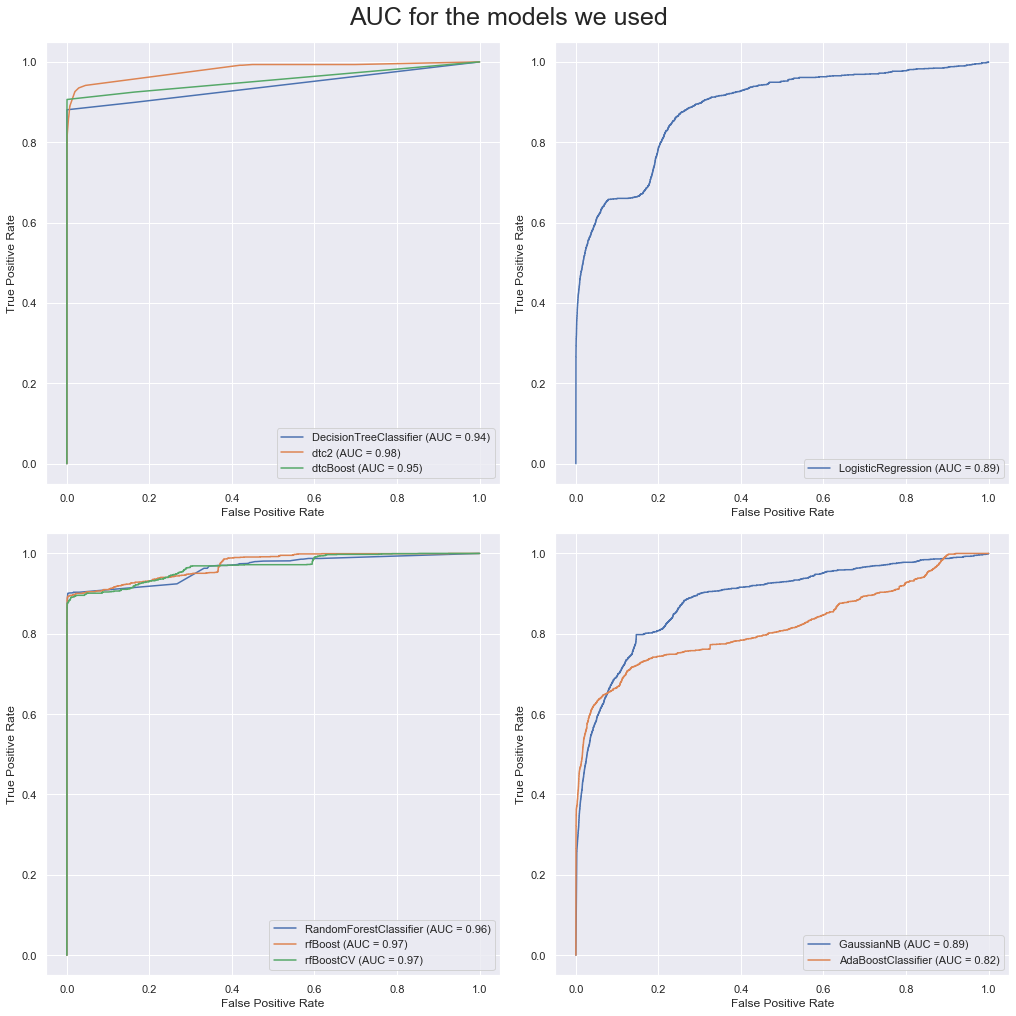

In [67]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 14), constrained_layout=True)
plot_roc_curve(dtc, X_test, y_test, ax=ax1)
plot_roc_curve(dtc2, X_test, y_test, ax=ax1, name='dtc2')
plot_roc_curve(dtcBoost, X_test, y_test, ax=ax1, name='dtcBoost')
plot_roc_curve(lr, X_test, y_test, ax=ax2)
plot_roc_curve(rf, X_test, y_test, ax=ax3)
plot_roc_curve(rfBoost, X_test, y_test, ax=ax3, name='rfBoost')
plot_roc_curve(rfBoostCV, X_test, y_test, ax=ax3, name='rfBoostCV')
# plot_roc_curve(svc, X_test, y_test, ax=ax)
plot_roc_curve(gnb, X_test, y_test, ax=ax4)
plot_roc_curve(gnbBoost, X_test, y_test, ax=ax4)

fig.suptitle ('AUC for the models we used', fontsize=supSize)
# ax.set_title('AUC for the models we used', fontsize=titleSize)
# ax.set_xlabel('Top Most Common Apps', fontsize=labelSize)
# ax.set_ylabel('App Size In Mb', fontsize=labelSize)
# ax.set_xticklabels(ax.get_xticklabels(), fontsize=tickSize)
# ax.set_yticklabels(ax.get_yticklabels(), fontsize=tickSize)

plt.show()

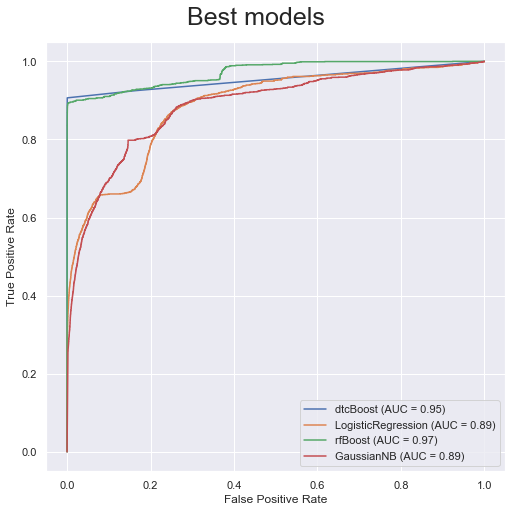

In [51]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)

plot_roc_curve(dtcBoost, X_test, y_test, ax=ax, name='dtcBoost')
plot_roc_curve(lr, X_test, y_test, ax=ax)
plot_roc_curve(rfBoost, X_test, y_test, ax=ax, name='rfBoost')
plot_roc_curve(gnb, X_test, y_test, ax=ax)

fig.suptitle ('Best models', fontsize=supSize)

plt.show()

in conclusion the best model is a Random forest with Adaboost

In [52]:
#fix score to be better

In [53]:
predictions = rfBoost.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.89626
The model is better then a 'dumb' model
confusion_matrix:
 [[552354     50]
 [   348   1330]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.96      0.79      0.87      1678

    accuracy                           1.00    554082
   macro avg       0.98      0.90      0.93    554082
weighted avg       1.00      1.00      1.00    554082



In [15]:
rf = RandomForestClassifier(max_depth=None, random_state=0, n_estimators=10)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.87415
The model is better then a 'dumb' model
confusion_matrix:
 [[1270855      28]
 [    413    1228]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1270883
         1.0       0.98      0.75      0.85      1641

    accuracy                           1.00   1272524
   macro avg       0.99      0.87      0.92   1272524
weighted avg       1.00      1.00      1.00   1272524



In [109]:
# def binarySearch (arr, l, r, x): 
#     # Check base case 
#     if r >= l: 
#         mid = l + (r - l)//2
#         # If element is present at the middle itself 
#         if arr[mid] == x: 
#             return mid 
          
#         # If element is smaller than mid, then it can only 
#         # be present in left subarray 
#         elif arr[mid] > x: 
#             return binarySearch(arr, l, mid-1, x) 
#         # Else the element can only be present in right subarray 
#         else: 
#             return binarySearch(arr, mid+1, r, x) 
#     else: 
#         # Element is not present in the array 
#         return -1

In [22]:
from sklearn.metrics import precision_recall_curve, average_precision_score
def optimalModel(model, y_test, X_test, scoring='roc_auc', average='macro'):
    y_pred = model.predict_proba(X_test)[:, 1]
    if scoring == 'roc_auc':  # cut run time
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        scores = []
        for x in thresholds:
            y_pred_class = binarize([y_pred], x)[0]
            scores.append(roc_auc_score(y_test, y_pred_class, average))
        scores = np.array(scores)
        index = np.argmax(scores)
    if scoring == 'average_precision':
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        scores = []
        for x in thresholds:
            y_pred_class = binarize([y_pred], x)[0]
            scores.append(average_precision_score(y_test, y_pred_class))
        scores = np.array(scores)
        index = np.argmax(scores)        
    if scoring == 'sensitivity':
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
        index = np.argmax(recall)
    if scoring == 'specificity':
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
        index = np.argmax(precision)
    y_pred_class = binarize([y_pred], thresholds[index])[0]
    evaluate(y_test, y_pred_class)
#     from sklearn.metrics import average_precision_score
    print(average_precision_score(y_test, y_pred))

In [20]:
optimalModel(rf, y_test, X_test, 'roc_auc', 'weighted')

Null AUC Score: 0.50000
Model AUC Score: 0.94704
The model is better then a 'dumb' model
confusion_matrix:
 [[1269467    1416]
 [    172    1469]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1270883
         1.0       0.51      0.90      0.65      1641

    accuracy                           1.00   1272524
   macro avg       0.75      0.95      0.82   1272524
weighted avg       1.00      1.00      1.00   1272524

0.8723629044638187


In [23]:
optimalModel(rf, y_test, X_test, 'roc_auc', 'samples')

Null AUC Score: 0.50000
Model AUC Score: 0.94704
The model is better then a 'dumb' model
confusion_matrix:
 [[1269467    1416]
 [    172    1469]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1270883
         1.0       0.51      0.90      0.65      1641

    accuracy                           1.00   1272524
   macro avg       0.75      0.95      0.82   1272524
weighted avg       1.00      1.00      1.00   1272524

0.8723629044638187


In [24]:
optimalModel(rf, y_test, X_test, 'roc_auc', 'micro')

Null AUC Score: 0.50000
Model AUC Score: 0.94704
The model is better then a 'dumb' model
confusion_matrix:
 [[1269467    1416]
 [    172    1469]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1270883
         1.0       0.51      0.90      0.65      1641

    accuracy                           1.00   1272524
   macro avg       0.75      0.95      0.82   1272524
weighted avg       1.00      1.00      1.00   1272524

0.8723629044638187


In [190]:
optimalModel(rf, y_test, X_test, 'roc_auc')

Null AUC Score: 0.50000
Model AUC Score: 0.94912
The model is better then a 'dumb' model
confusion_matrix:
 [[550834   1570]
 [   166   1512]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.49      0.90      0.64      1678

    accuracy                           1.00    554082
   macro avg       0.75      0.95      0.82    554082
weighted avg       1.00      1.00      1.00    554082

0.8786148687310609


In [25]:
optimalModel(rf, y_test, X_test, 'average_precision')

Null AUC Score: 0.50000
Model AUC Score: 0.88542
The model is better then a 'dumb' model
confusion_matrix:
 [[1270838      45]
 [    376    1265]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1270883
         1.0       0.97      0.77      0.86      1641

    accuracy                           1.00   1272524
   macro avg       0.98      0.89      0.93   1272524
weighted avg       1.00      1.00      1.00   1272524

0.8723629044638187


In [26]:
optimalModel(rf, y_test, X_test, 'sensitivity')

Null AUC Score: 0.50000
Model AUC Score: 0.83753
The model is better then a 'dumb' model
confusion_matrix:
 [[859463 411420]
 [     2   1639]]
              precision    recall  f1-score   support

         0.0       1.00      0.68      0.81   1270883
         1.0       0.00      1.00      0.01      1641

    accuracy                           0.68   1272524
   macro avg       0.50      0.84      0.41   1272524
weighted avg       1.00      0.68      0.81   1272524

0.8723629044638187


In [27]:
optimalModel(rf, y_test, X_test, 'specificity')

Null AUC Score: 0.50000
Model AUC Score: 0.81231
The model is better then a 'dumb' model
confusion_matrix:
 [[1270883       0]
 [    616    1025]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1270883
         1.0       1.00      0.62      0.77      1641

    accuracy                           1.00   1272524
   macro avg       1.00      0.81      0.88   1272524
weighted avg       1.00      1.00      1.00   1272524

0.8723629044638187


In [56]:
rfBoost = AdaBoostClassifier(base_estimator=rf, n_estimators=10, random_state=0)
rfBoost.fit(X_train, y_train)
predictions = rfBoost.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.89626
The model is better then a 'dumb' model
confusion_matrix:
 [[552354     50]
 [   348   1330]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.96      0.79      0.87      1678

    accuracy                           1.00    554082
   macro avg       0.98      0.90      0.93    554082
weighted avg       1.00      1.00      1.00    554082



In [57]:
y_pred = rfBoost.predict_proba(X_test)[:, 1]
y_pred_class = binarize([y_pred], 3e-1)[0]
evaluate(y_test, y_pred_class)

Null AUC Score: 0.50000
Model AUC Score: 0.93388
The model is better then a 'dumb' model
confusion_matrix:
 [[552103    301]
 [   221   1457]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.83      0.87      0.85      1678

    accuracy                           1.00    554082
   macro avg       0.91      0.93      0.92    554082
weighted avg       1.00      1.00      1.00    554082



In [58]:
# rfBoost = AdaBoostClassifier(base_estimator=rf, n_estimators=20, learning_rate=1, random_state=0)
# rfBoost.fit(X_train, y_train)
# predictions = rfBoost.predict(X_test)
# evaluate(y_test, predictions)

In [59]:
# rfBoost = AdaBoostClassifier(base_estimator=rf, n_estimators=20, learning_rate=0.5, random_state=0)
# rfBoost.fit(X_train, y_train)
# predictions = rfBoost.predict(X_test)
# evaluate(y_test, predictions)

### Improve existing fraud detection

In [28]:
# Existing fraud doesnt always work
df[df['amount']==df['oldbalanceOrg']]['isFlaggedFraud'].value_counts()

0.0    16
Name: isFlaggedFraud, dtype: int64

In [29]:
# df['myFlaggedFraud'] = df['isFlaggedFraud']
# size = len(df[df['amount']==df['oldbalanceOrg']]['isFlaggedFraud'])
d1 = df[df['amount']==df['oldbalanceOrg']]['isFlaggedFraud']
d2 = df[df['amount']!=df['oldbalanceOrg']]['isFlaggedFraud']
d1 = d1.replace(0, 1)
df['isFlaggedFraud'] = pd.concat([d1, d2])

In [30]:
df[df['amount']==df['oldbalanceOrg']]['isFlaggedFraud'].value_counts()

1.0    16
Name: isFlaggedFraud, dtype: int64

### Run our best model again with improved fraud detection

In [31]:
X=df.drop('isFraud', axis=1)
y=df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [32]:
rf = RandomForestClassifier(max_depth=None, random_state=0, n_estimators=10)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.88542
The model is better then a 'dumb' model
confusion_matrix:
 [[1270835      48]
 [    376    1265]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1270883
         1.0       0.96      0.77      0.86      1641

    accuracy                           1.00   1272524
   macro avg       0.98      0.89      0.93   1272524
weighted avg       1.00      1.00      1.00   1272524



In [33]:
optimalModel(rf, y_test, X_test, 'roc_auc')

Null AUC Score: 0.50000
Model AUC Score: 0.95898
The model is better then a 'dumb' model
confusion_matrix:
 [[1269631    1252]
 [    133    1508]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1270883
         1.0       0.55      0.92      0.69      1641

    accuracy                           1.00   1272524
   macro avg       0.77      0.96      0.84   1272524
weighted avg       1.00      1.00      1.00   1272524

0.8889202403815625


In [34]:
optimalModel(rf, y_test, X_test, 'average_precision')

Null AUC Score: 0.50000
Model AUC Score: 0.89729
The model is better then a 'dumb' model
confusion_matrix:
 [[1270809      74]
 [    337    1304]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1270883
         1.0       0.95      0.79      0.86      1641

    accuracy                           1.00   1272524
   macro avg       0.97      0.90      0.93   1272524
weighted avg       1.00      1.00      1.00   1272524

0.8889202403815625


In [63]:
cross_val_score
#     print(average_precision_score(y_test, y_pred_class))

<function sklearn.model_selection._validation.cross_val_score(estimator, X, y=None, groups=None, scoring=None, cv=None, n_jobs=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', error_score=nan)>